### DBSCAN applied on linear regression

In the following notebook we're going to see how DBSCAN can improve a simple Linear Regression. For the purpose we're going to use a dataset from kaggle [FuelConsumptionCo2.csv](https://www.kaggle.com/ramlalnaik/predicting-the-co2-emissions).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid")

import warnings
warnings.filterwarnings("ignore")

path = "C:/Users/Orr/Documents/DataScience_2020/Neoland/GITHUB_projects/project/2.Clustering/DBSCAN/data/"
img_path = 'C:/Users/Orr/Documents/DataScience_2020/Neoland/GITHUB_projects/project/2.Clustering/DBSCAN/img/'
file = "FuelConsumptionCo2.csv"

To start we just import the file and check for eventual null data and the correlation between the columns

In [2]:
df = pd.read_csv(path+file)
print(df.shape)
df.head()

(1067, 13)


,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


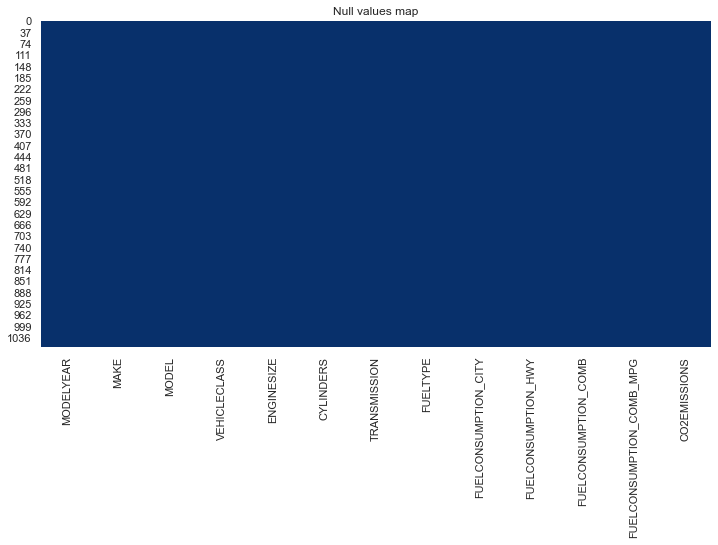

In [3]:
fig = plt.figure(figsize = (12,6))
plt.title("Null values map")
sns.heatmap(df.isnull(), cbar = False, cmap = "Blues_r")
plt.show()

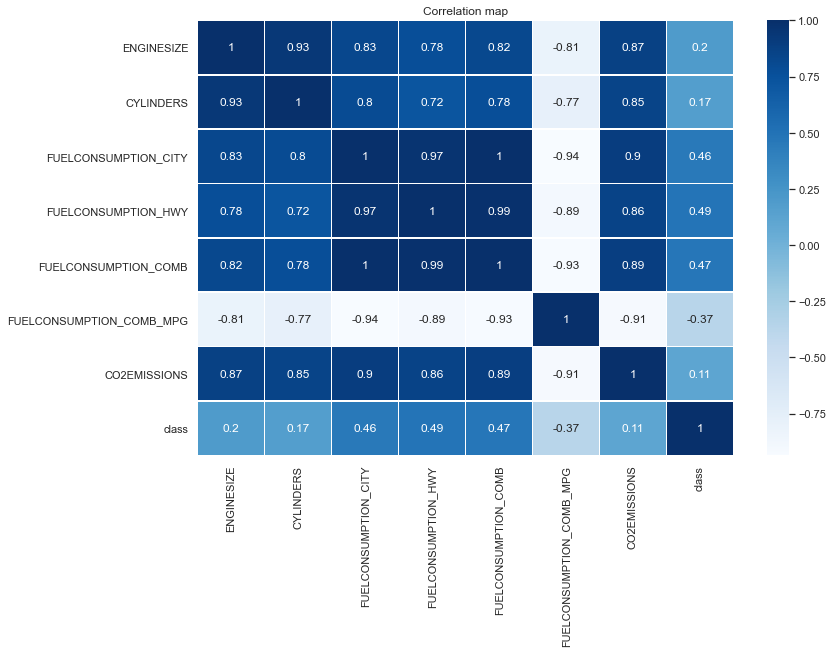

In [192]:
fig = plt.figure(figsize = (12, 8))
plt.title("Correlation map")
sns.heatmap(df.drop("MODELYEAR", axis = 1).corr(),annot = True, cmap = "Blues", linewidths = .5)
plt.show()

using [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) we can take a look at the relationship between the numerical variables of the dataframe

<Figure size 432x288 with 0 Axes>

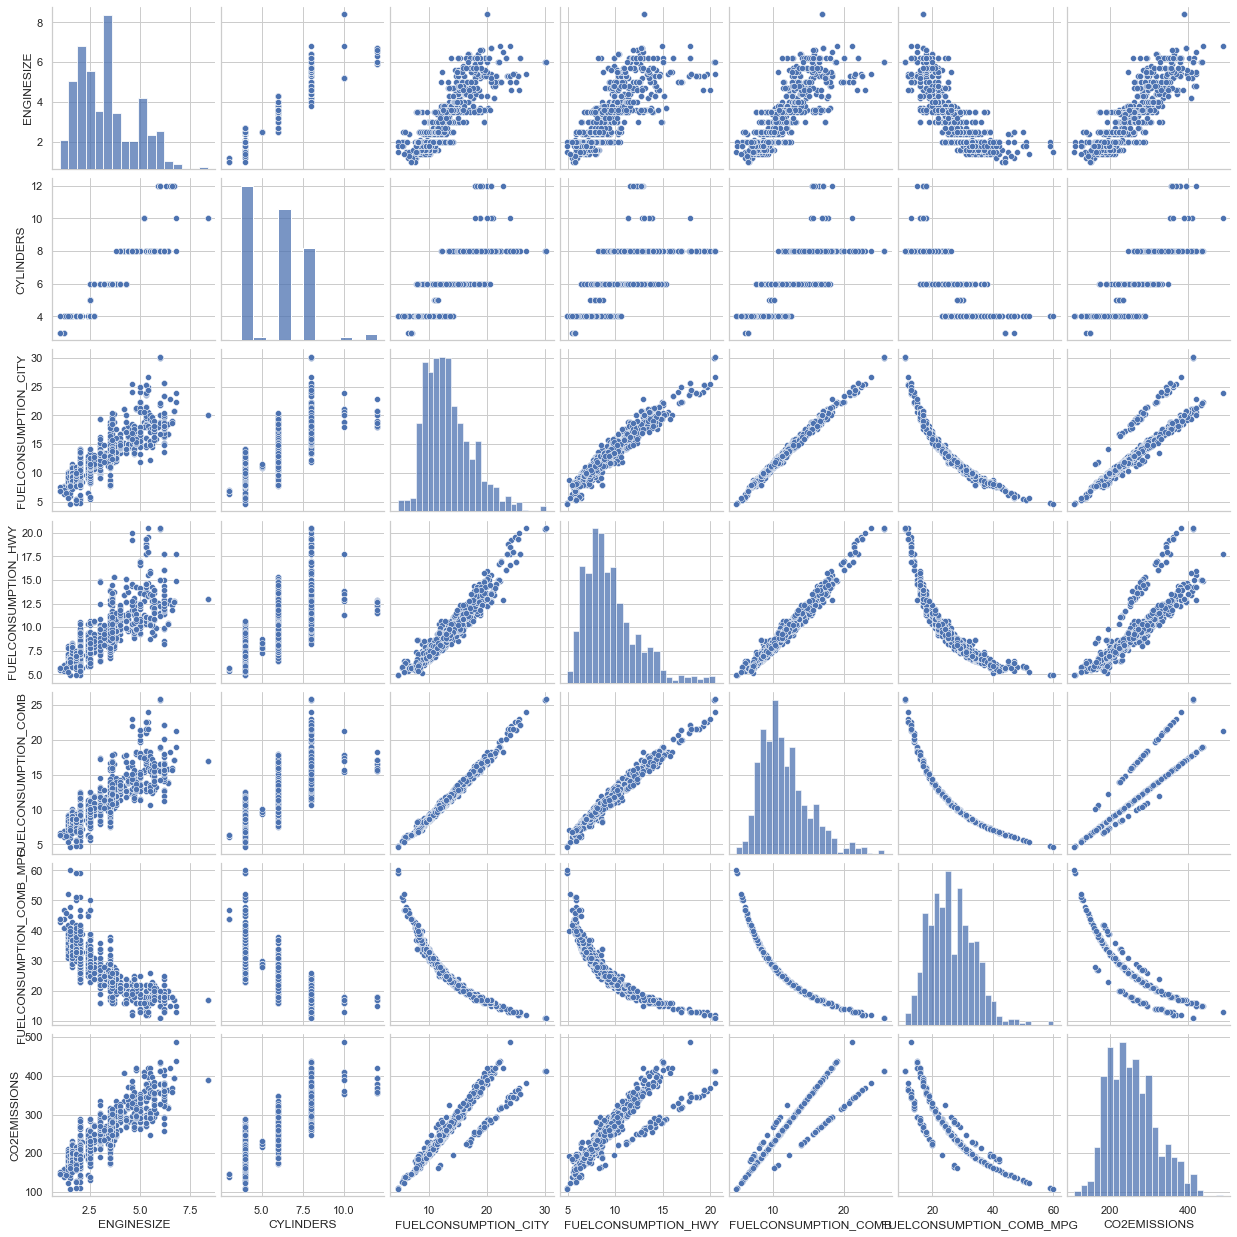

In [11]:
df1 = df[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS']]

fig = plt.figure()
sns.pairplot(df1,palette = "Paired" )
fig.tight_layout()
plt.show()

We can take in consideration the variable FUELCONSUMPTION_CITY to predict the CO2EMISSIONS generated by the car during a city tour. 

First we will use a Linear Regression to predict the CO2 emissions and test its score, then we'll repeat the process this time once per each cluster discovereb by the DBSCAN.

In [88]:
from sklearn.model_selection import train_test_split

X = df["FUELCONSUMPTION_CITY"].values.reshape(1067, 1)
y = df["CO2EMISSIONS"].values

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

Now apply the LinearRegression to the train set and extract the intercept. We'll use it to plot the Linear Regression on the data following the simple formula:

$$ y = mx + c $$

Where m is the slope or coefficient and c is the intercept.


In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

regression = LinearRegression()
regression.fit(X_train, y_train)
intercept = regression.intercept_
coefficient = regression.coef_


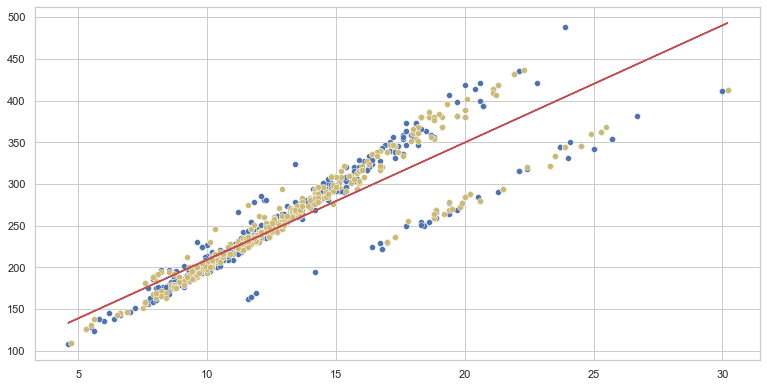

Predicted value: 313.19955239380135; Actual value: 338
R squared score: 0.7644049320053408


In [130]:
fig = plt.figure(figsize = (13,6.5))
sns.scatterplot(X_train.flatten(), y_train.flatten(), color = "b")
sns.scatterplot(X_test.flatten(), y_test.flatten(), color = "y")

#y = mx+c
plt.plot(X_train, coefficient[0] * X_train + intercept, "r-")

plt.show()

y_pred = regression.predict(X_test)

for i, j in zip(y_pred, y_test):
    print("Predicted value: {}; Actual value: {}".format(i, j))
    break
regression_score = r2_score(y_pred, y_test)
print("R squared score: {}".format(regression_score))

The Linear Regression on its own doesn't obtain an impressive score, given the structure of the data a more complex form of regression would score better.

However a remarkable improvement can be achieved using DBSCAN, let's see how.

To start we create a new dataframe with the variables we'll use with the model, then we use MinMaxScaler from sklearn to normalize the data.

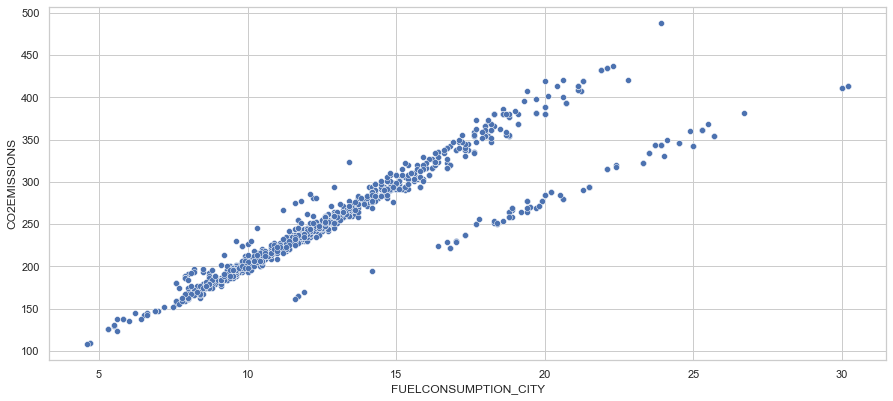

In [117]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

model_df = df[["FUELCONSUMPTION_CITY", "CO2EMISSIONS"]]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(model_df)

fig = plt.figure(figsize = (15, 6.5))
sns.scatterplot(model_df["FUELCONSUMPTION_CITY"], model_df["CO2EMISSIONS"], color = "b")
plt.show()


Before applying DBSCAN, in order to find an ideal epsilon parameter, we can use NearestNeighbors to calculate the distances between 1 point and the closest one. Once obtained the distances we can plot them with the purpose of finding the maximum curvature point, which will represent the ideal eps, the threshold of similarity.

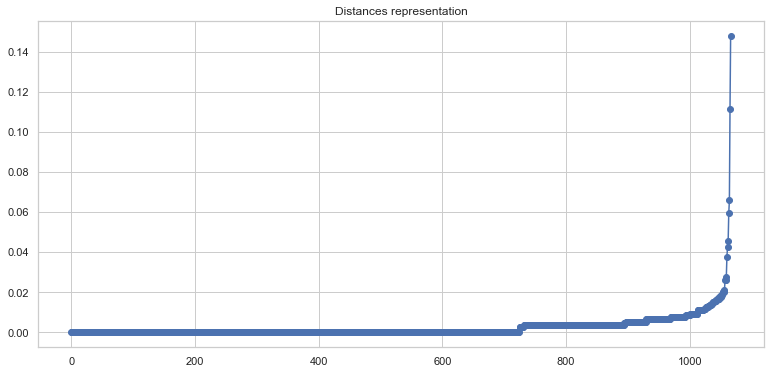

In [118]:
from sklearn.neighbors import NearestNeighbors

N = NearestNeighbors(n_neighbors = 2).fit(scaled_df)
distances, indices = N.kneighbors(scaled_df)

sort_dist = np.sort(distances, axis = 0)

fig = plt.figure(figsize= (13,6))
plt.title("Distances representation")
plt.plot(sort_dist[:, 1], "b-o")
plt.show()

From the graph it appears that the ideal value for eps is between 0.11 and 0.12, to verify we can apply the parameters to DBSCAN, start the algorithm and visualize it: 

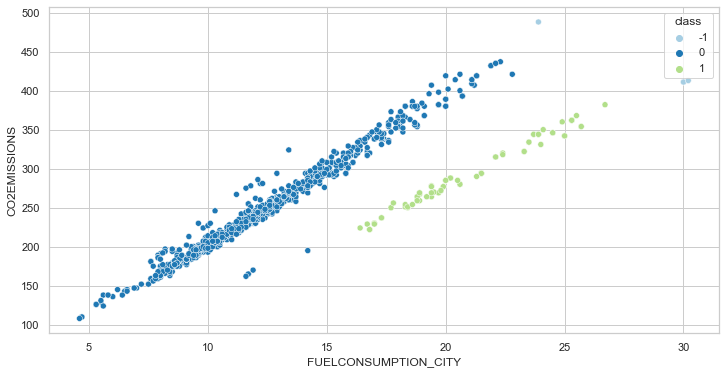

In [145]:
db = DBSCAN(eps = 0.12, min_samples = 10).fit(scaled_df)
labels = db.labels_
model_df["class"] = labels
df["class"] = labels

fig = plt.figure(figsize = (12, 6))
sns.scatterplot(model_df["FUELCONSUMPTION_CITY"], model_df["CO2EMISSIONS"], hue = model_df["class"], palette = "Paired")
plt.show()

Now that we have clearly obtained 2 separate clusters we can apply the Linear Regression on each:

#### CLASS 0

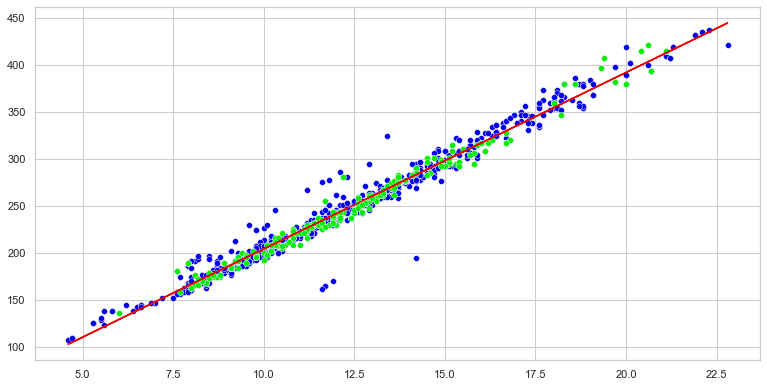

0.9811263292627952


In [170]:
X = model_df[model_df["class"]==0]["FUELCONSUMPTION_CITY"].values
y = model_df[model_df["class"]==0]["CO2EMISSIONS"].values

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y, test_size=0.20)

#Fit the regression to the train set and calculate coefficient and intercept
regression1 = LinearRegression()
regression1.fit(X_train, y_train)
coef1 = regression1.coef_
intercept1 = regression1.intercept_

fig = plt.figure(figsize = (13,6.5))
plt.title("Linear Regression on class 0")
#train test
sns.scatterplot(X_train.flatten(), y_train.flatten(), color = "#00e")

#actual values
sns.scatterplot(X_test.flatten(), y_test.flatten(), color = "#0e0")

#y = mx+c
plt.plot(X_train, coef1[0] * X_train + intercept1, color = "#e00")

plt.show()

y_pred = regression.predict(X_test)
print(r2_score(y_test, y_pred))

#### CLASS 1

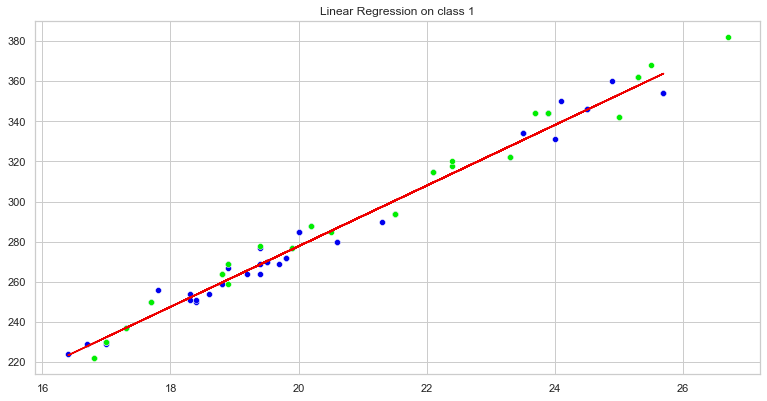

0.9795971537478634


In [178]:
X = model_df[model_df["class"]==1]["FUELCONSUMPTION_CITY"].values
y = model_df[model_df["class"]==1]["CO2EMISSIONS"].values

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size = 0.33)

regression2 = LinearRegression()
regression2.fit(X_train, y_train)
coef2 = regression2.coef_
intercept2 = regression2.intercept_
y_pred = regression2.predict(X_test)

fig = plt.figure(figsize = (13,6.5))
plt.title("Linear Regression on class 1")

sns.scatterplot(X_train.flatten(), y_train.flatten(), color = "#00e")

sns.scatterplot(X_test.flatten(), y_test.flatten(), color = "#0e0")

plt.plot(X_train, coef2[0] * X_train + intercept2, color = "#e00")
plt.show()

print(r2_score(y_test, y_pred))

We started with a simple LinearRegression obtaining a r2_score around 0.65, but after discovering 2 different clusters with DBSCAN we managed to increase the accuracy by 30% circa. 

Now we can fit the Linear Regressions to our data and see how it behaves:

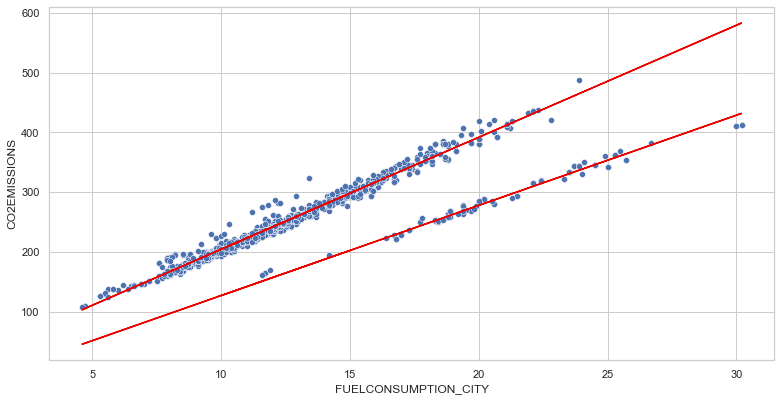

In [186]:
fig  = plt.figure(figsize=(13,6.5))
sns.scatterplot(df["FUELCONSUMPTION_CITY"], df["CO2EMISSIONS"], color = "b")
plt.plot(df["FUELCONSUMPTION_CITY"], coef1*df["FUELCONSUMPTION_CITY"]+intercept1, "#e00")
plt.plot(df["FUELCONSUMPTION_CITY"], coef2*df["FUELCONSUMPTION_CITY"]+intercept2, "#e00")
plt.show()

___